# SSDLite_FPN 训练笔记

## 安装依赖

In [1]:
!pip -q install torchvision
!pip -q install tqdm
!pip -q install timm

## 导入工程

In [2]:
# 导入系统库
import os
import timm
from tqdm import tqdm

# 导入sparrow
from sparrow.models.ssdlite_fpn import SSDLite_FPN
from sparrow.datasets.coco_dets import create_dets_dataloader
from sparrow.losses.ssdlite_loss import SSDLoss, AnchorGenerator
from sparrow.utils.torch_utils import EMA, evaluate, visualize_predictions
from torch.optim.lr_scheduler import CosineAnnealingLR

# 导入torch库
import torch

/home/cxt/miniconda3/envs/sparrow/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 参数设置

### 系统参数

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
INPUT_SIZE = 320
BATCH_SIZE = 8
NUM_WORKERS = 4
NUM_CLASSES = 80 # COCO 数据集定义数
ANCHOR_SIZES = [32, 64, 128, 256, 512]
ANCHOR_RATIOS = [0.5, 1.0, 2.0, 1/3.0, 3.0]

WEIGHTS_DIR = "./outputs/ssdlite" # 保存权重的目录
TEST_IMAGE_PATH = "./res/india_road.png" # 你的测试图片路径

### 学习参数

In [4]:
START_EPOCH = 0
LOG_INTERVAL_SAMPLES = 1000
EPOCHS=100
log_interval_batches = max(1, LOG_INTERVAL_SAMPLES // BATCH_SIZE)
BEST_VAL_LOSS = float('inf')
LEARNING_RATE = 1e-4 # 初始学习率
WEIGHT_DECAY = 1e-3
WARMUP_EPOCHS = 2 # <--- 新增：预热的 epoch 数量
GRADIENT_CLIP_VAL = 5.0 # <--- 新增：梯度裁剪的阈值

## 创建模型

In [5]:
backbone_fpn = timm.create_model('mobilenetv3_large_100', pretrained=True, features_only=True, out_indices=(2, 3, 4))
model_fpn = SSDLite_FPN(backbone_fpn, num_classes=NUM_CLASSES, fpn_out_channels=128, num_anchors=len(ANCHOR_RATIOS))
model_fpn.to(device)

# EMA评估器
ema = EMA(model_fpn)

Unexpected keys (classifier.bias, classifier.weight, conv_head.bias, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


## 加载数据

In [6]:
COCO_ROOT = "/home/cxt/projects/MobileSparrow/data/coco2017"

# 数据加载器 (来自 dataloader.py)
train_aug_config = { "rotate_deg": 15.0, "min_box_size": 2.0 }
train_loader = create_dets_dataloader(
    dataset_root=COCO_ROOT,
    img_size=INPUT_SIZE,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    aug_cfg=train_aug_config,
    is_train=True
)

# --- 新增：创建验证集数据加载器 ---
val_aug_config = { "min_box_size": 2.0 } # 验证集通常不做复杂增强
val_loader = create_dets_dataloader(
    dataset_root=COCO_ROOT,
    img_size=INPUT_SIZE,
    batch_size=BATCH_SIZE * 2,  # 验证时通常可以用更大的 batch size
    num_workers=NUM_WORKERS,
    pin_memory=True,
    aug_cfg=val_aug_config,
    is_train=False
)

/home/cxt/projects/MobileSparrow/sparrow/datasets/coco_dets.py:103: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  transforms.append(A.PadIfNeeded(
/home/cxt/miniconda3/envs/sparrow/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/home/cxt/projects/MobileSparrow/sparrow/datasets/coco_dets.py:116: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  transforms.append(A.ShiftScaleRotate(


## 损失优化调度

In [7]:
# 损失函数
criterion = SSDLoss(num_classes=NUM_CLASSES)

# 优化器
optimizer = torch.optim.AdamW(model_fpn.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# 学习调度器
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6) 

## 加载预训练权重

确保每次训练不必从头再来。

In [8]:
# 确保存放预训练的目录存在
os.makedirs(WEIGHTS_DIR, exist_ok=True) # 确保目录存在

# 断点续训逻辑
last_pt_path = os.path.join(WEIGHTS_DIR, "last.pt")
if os.path.exists(last_pt_path):
    print("--- Resuming training from last.pt ---")

    # 加载pt文件
    checkpoint = torch.load(last_pt_path, map_location=device)
    
    # 从pt中读取模型权重
    model_fpn.load_state_dict(checkpoint['model'])
    
    # 加载EMA状态
    ema.ema_model.load_state_dict(checkpoint['ema_model'])

    # 加载优化器状态
    optimizer.load_state_dict(checkpoint['optimizer'])

    # 加载调度器状态
    scheduler.load_state_dict(checkpoint['scheduler'])

    # 更新EPOCH状态
    START_EPOCH = checkpoint['epoch'] + 1
    
    # 更新最佳损失状态
    BEST_VAL_LOSS = checkpoint['best_val_loss']
    
    # 打印确认消息
    print(f"Resumed from epoch {START_EPOCH-1}. Best validation loss so far: {BEST_VAL_LOSS:.4f}")
    print(f"Current learning rate is {optimizer.param_groups[0]['lr']:.6f}")



## 预处理 anchor boxes

In [9]:
# --- 预计算锚框 (核心步骤) ---
print("Pre-computing anchors for fixed input size...")
anchor_generator = AnchorGenerator(
    sizes=ANCHOR_SIZES,
    aspect_ratios=ANCHOR_RATIOS
)

# 创建一个虚拟输入
dummy_input = torch.randn(1, 3, INPUT_SIZE, INPUT_SIZE).to(device)

# 设置为 eval 模式，并确保没有梯度计算
model_fpn.eval()
with torch.no_grad():
    # 手动执行一次特征提取流程，以获取特征图尺寸
    features = model_fpn.backbone(dummy_input)
    p3, p4, p5 = model_fpn.fpn(features)
    p6 = model_fpn.extra_layers[0](p5)
    p7 = model_fpn.extra_layers[1](p6)
    feature_maps_for_size_calc = [p3, p4, p5, p6, p7]

# 使用获取的特征图列表生成一次性的、完整的锚框网格
# 这个 precomputed_anchors 将在整个训练过程中被重复使用
precomputed_anchors = anchor_generator.generate_anchors_on_grid(feature_maps_for_size_calc, device)
print(f"Anchors pre-computed. Shape: {precomputed_anchors.shape}")

Pre-computing anchors for fixed input size...
Anchors pre-computed. Shape: torch.Size([10670, 4])


## 启动训练循环


--- Starting Training ---
Logging average loss every 125 batches.


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 48.39it/s, cls=18440.9297, reg=6.4282] 



---> Epoch 1/100 Validation Summary <---
  Average Validation Loss: 11468.8598
  Saved last checkpoint to ./outputs/ssdlite/last.pt
  >>> New best model found! Saved to ./outputs/ssdlite/best.pt



[Validating]: 100%|██████████| 313/313 [00:06<00:00, 49.75it/s, cls=15.2372, reg=10.3073]



---> Epoch 2/100 Validation Summary <---
  Average Validation Loss: 23.5791
  Saved last checkpoint to ./outputs/ssdlite/last.pt
  >>> New best model found! Saved to ./outputs/ssdlite/best.pt



[Validating]: 100%|██████████| 313/313 [00:06<00:00, 50.34it/s, cls=13.0592, reg=6.9540] 



---> Epoch 3/100 Validation Summary <---
  Average Validation Loss: 20.3773
  Saved last checkpoint to ./outputs/ssdlite/last.pt
  >>> New best model found! Saved to ./outputs/ssdlite/best.pt



[Validating]: 100%|██████████| 313/313 [00:06<00:00, 49.56it/s, cls=23.8392, reg=12.8332]



---> Epoch 4/100 Validation Summary <---
  Average Validation Loss: 28.4007
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 49.93it/s, cls=39.4093, reg=21.0353]



---> Epoch 5/100 Validation Summary <---
  Average Validation Loss: 44.2994
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 49.86it/s, cls=120.3102, reg=47.8378]



---> Epoch 6/100 Validation Summary <---
  Average Validation Loss: 182.9853
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 50.29it/s, cls=248.3688, reg=73.4332] 



---> Epoch 7/100 Validation Summary <---
  Average Validation Loss: 508.9738
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 49.43it/s, cls=4098.9775, reg=387.9400] 



---> Epoch 8/100 Validation Summary <---
  Average Validation Loss: 3441.8717
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 49.48it/s, cls=13388.1475, reg=541.9713]



---> Epoch 9/100 Validation Summary <---
  Average Validation Loss: 15017.8274
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 50.04it/s, cls=217192.8750, reg=3948.5051]



---> Epoch 10/100 Validation Summary <---
  Average Validation Loss: 222896.4424
  Saved last checkpoint to ./outputs/ssdlite/last.pt

--- Visualizing predictions at epoch 10 ---


/home/cxt/miniconda3/envs/sparrow/lib/python3.10/site-packages/matplotlib/patches.py:796: RuntimeWarning: invalid value encountered in scalar add
  x1 = self.convert_xunits(self._x0 + self._width)
/home/cxt/miniconda3/envs/sparrow/lib/python3.10/site-packages/matplotlib/patches.py:797: RuntimeWarning: invalid value encountered in scalar add
  y1 = self.convert_yunits(self._y0 + self._height)
/home/cxt/miniconda3/envs/sparrow/lib/python3.10/site-packages/matplotlib/transforms.py:2037: RuntimeWarning: invalid value encountered in scalar add
  self._mtx[1, 2] += ty
/home/cxt/miniconda3/envs/sparrow/lib/python3.10/site-packages/matplotlib/transforms.py:2036: RuntimeWarning: invalid value encountered in scalar add
  self._mtx[0, 2] += tx
/home/cxt/miniconda3/envs/sparrow/lib/python3.10/site-packages/matplotlib/transforms.py:352: RuntimeWarning: invalid value encountered in scalar subtract
  return points[1, 0] - points[0, 0]


ValueError: Image size of 10878180x7552612 pixels is too large. It must be less than 2^23 in each direction.

<Figure size 1200x900 with 1 Axes>

[Validating]: 100%|██████████| 313/313 [00:06<00:00, 51.50it/s, cls=320625.4062, reg=5752.0381]



---> Epoch 11/100 Validation Summary <---
  Average Validation Loss: 294363.9732
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 51.11it/s, cls=540852.0000, reg=11515.0000] 



---> Epoch 12/100 Validation Summary <---
  Average Validation Loss: 643777.8290
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 51.18it/s, cls=335294.1875, reg=7742.2207] 



---> Epoch 13/100 Validation Summary <---
  Average Validation Loss: 268054.0921
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 50.96it/s, cls=738427.0625, reg=12478.4600] 



---> Epoch 14/100 Validation Summary <---
  Average Validation Loss: 531423.8475
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 51.83it/s, cls=532704.5625, reg=8599.3105] 



---> Epoch 15/100 Validation Summary <---
  Average Validation Loss: 361016.8913
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 51.05it/s, cls=150098.3281, reg=6721.3164] 



---> Epoch 16/100 Validation Summary <---
  Average Validation Loss: 153326.1360
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 51.24it/s, cls=96871.9219, reg=6042.8105]  



---> Epoch 17/100 Validation Summary <---
  Average Validation Loss: 223190.2297
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 51.48it/s, cls=482615.4688, reg=5683.6416]  



---> Epoch 18/100 Validation Summary <---
  Average Validation Loss: 485546.6128
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 51.94it/s, cls=354086.4062, reg=12103.8057] 



---> Epoch 19/100 Validation Summary <---
  Average Validation Loss: 424104.6502
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 50.93it/s, cls=809475.7500, reg=12150.9482] 



---> Epoch 20/100 Validation Summary <---
  Average Validation Loss: 610747.9722
  Saved last checkpoint to ./outputs/ssdlite/last.pt

--- Visualizing predictions at epoch 20 ---


ValueError: Image size of 70929364x64663550 pixels is too large. It must be less than 2^23 in each direction.

<Figure size 1200x900 with 1 Axes>

[Validating]: 100%|██████████| 313/313 [00:06<00:00, 51.45it/s, cls=557655.3125, reg=10245.5459] 



---> Epoch 21/100 Validation Summary <---
  Average Validation Loss: 492739.9891
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 50.83it/s, cls=221408.4531, reg=8267.5098]  



---> Epoch 22/100 Validation Summary <---
  Average Validation Loss: 412811.4801
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 51.66it/s, cls=244922.2656, reg=5261.6470]



---> Epoch 23/100 Validation Summary <---
  Average Validation Loss: 135182.4435
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 51.60it/s, cls=19626.9375, reg=5188.8564]  



---> Epoch 24/100 Validation Summary <---
  Average Validation Loss: 82912.6336
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 51.23it/s, cls=567880.2500, reg=15414.1523] 



---> Epoch 25/100 Validation Summary <---
  Average Validation Loss: 537568.0280
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 50.56it/s, cls=600126.3750, reg=12853.8135] 



---> Epoch 26/100 Validation Summary <---
  Average Validation Loss: 569576.5359
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 51.55it/s, cls=350122.9688, reg=8454.3506] 



---> Epoch 27/100 Validation Summary <---
  Average Validation Loss: 223647.6747
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 51.46it/s, cls=249938.8906, reg=5840.3945] 



---> Epoch 28/100 Validation Summary <---
  Average Validation Loss: 205919.9569
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 50.97it/s, cls=1661089.2500, reg=24369.0625]



---> Epoch 29/100 Validation Summary <---
  Average Validation Loss: 740426.9601
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 51.01it/s, cls=907246.8750, reg=16777.2051] 



---> Epoch 30/100 Validation Summary <---
  Average Validation Loss: 633876.1540
  Saved last checkpoint to ./outputs/ssdlite/last.pt

--- Visualizing predictions at epoch 30 ---


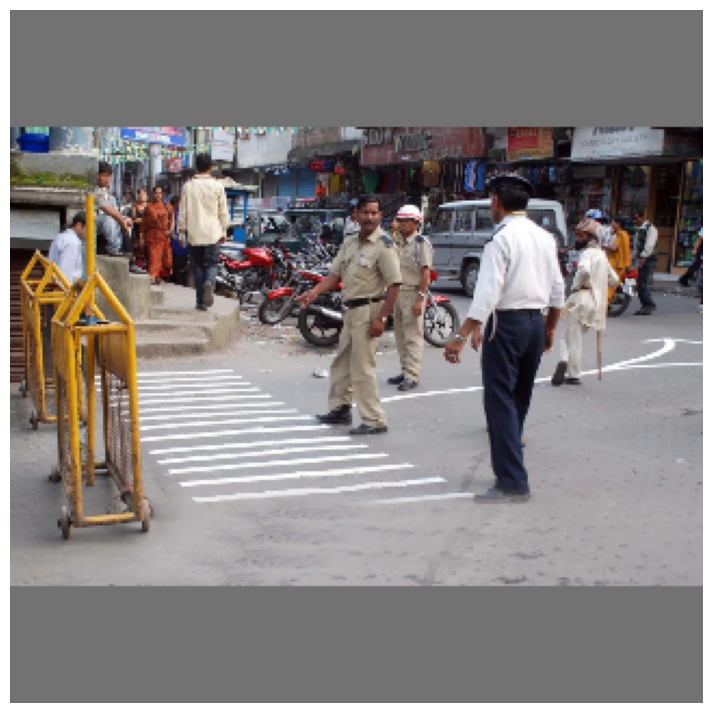

[Validating]: 100%|██████████| 313/313 [00:06<00:00, 51.23it/s, cls=2646838.2500, reg=42799.6211]



---> Epoch 31/100 Validation Summary <---
  Average Validation Loss: 1458323.6920
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 50.52it/s, cls=2203427.7500, reg=46535.8945]



---> Epoch 32/100 Validation Summary <---
  Average Validation Loss: 1600925.8584
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 50.71it/s, cls=3478170.5000, reg=63598.9180]



---> Epoch 33/100 Validation Summary <---
  Average Validation Loss: 2305279.9495
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 51.17it/s, cls=3626934.2500, reg=59920.5586]



---> Epoch 34/100 Validation Summary <---
  Average Validation Loss: 2716621.0220
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 50.53it/s, cls=984062.4375, reg=38905.1523] 



---> Epoch 35/100 Validation Summary <---
  Average Validation Loss: 1064641.4429
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 50.81it/s, cls=3725126.5000, reg=69273.8828] 



---> Epoch 36/100 Validation Summary <---
  Average Validation Loss: 2642057.8991
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 51.09it/s, cls=4052601.5000, reg=84770.4141] 



---> Epoch 37/100 Validation Summary <---
  Average Validation Loss: 2549490.0534
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 50.98it/s, cls=2557769.2500, reg=52587.5039] 



---> Epoch 38/100 Validation Summary <---
  Average Validation Loss: 2736486.3612
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 51.02it/s, cls=2993028.2500, reg=58879.7812] 



---> Epoch 39/100 Validation Summary <---
  Average Validation Loss: 2448088.3819
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 49.87it/s, cls=3062187.2500, reg=66401.5859] 



---> Epoch 40/100 Validation Summary <---
  Average Validation Loss: 3552862.1633
  Saved last checkpoint to ./outputs/ssdlite/last.pt

--- Visualizing predictions at epoch 40 ---


ValueError: Image size of 347497281x402366575 pixels is too large. It must be less than 2^23 in each direction.

<Figure size 1200x900 with 1 Axes>

[Validating]: 100%|██████████| 313/313 [00:06<00:00, 50.34it/s, cls=4258119.5000, reg=87053.5703]  



---> Epoch 41/100 Validation Summary <---
  Average Validation Loss: 4143935.7434
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 51.21it/s, cls=4173067.2500, reg=99731.7891]  



---> Epoch 42/100 Validation Summary <---
  Average Validation Loss: 4250077.8894
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 50.38it/s, cls=2290591.2500, reg=61543.5078]



---> Epoch 43/100 Validation Summary <---
  Average Validation Loss: 3020268.4066
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 50.39it/s, cls=1159576.5000, reg=44110.5234]



---> Epoch 44/100 Validation Summary <---
  Average Validation Loss: 2068030.9980
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 51.50it/s, cls=1608296.0000, reg=47754.4766]



---> Epoch 45/100 Validation Summary <---
  Average Validation Loss: 1897695.3651
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 50.80it/s, cls=6654466.0000, reg=144537.3281] 



---> Epoch 46/100 Validation Summary <---
  Average Validation Loss: 7676348.9588
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 51.30it/s, cls=8796729.0000, reg=161726.6250] 



---> Epoch 47/100 Validation Summary <---
  Average Validation Loss: 8484391.1960
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 50.34it/s, cls=5508820.0000, reg=106430.3672] 



---> Epoch 48/100 Validation Summary <---
  Average Validation Loss: 6762068.9778
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 49.69it/s, cls=6426415.5000, reg=151185.1250] 



---> Epoch 49/100 Validation Summary <---
  Average Validation Loss: 7886255.8541
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 50.15it/s, cls=12186960.0000, reg=256710.2656]



---> Epoch 50/100 Validation Summary <---
  Average Validation Loss: 11887259.0696
  Saved last checkpoint to ./outputs/ssdlite/last.pt

--- Visualizing predictions at epoch 50 ---


ValueError: Image size of 2421377362x1297948552 pixels is too large. It must be less than 2^23 in each direction.

<Figure size 1200x900 with 1 Axes>

[Validating]: 100%|██████████| 313/313 [00:06<00:00, 50.49it/s, cls=12392444.0000, reg=227789.4688]



---> Epoch 51/100 Validation Summary <---
  Average Validation Loss: 12194829.9681
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 51.06it/s, cls=11858197.0000, reg=211691.9375]



---> Epoch 52/100 Validation Summary <---
  Average Validation Loss: 10686205.2125
  Saved last checkpoint to ./outputs/ssdlite/last.pt


[Validating]: 100%|██████████| 313/313 [00:06<00:00, 50.94it/s, cls=13562122.0000, reg=352049.1250]



---> Epoch 53/100 Validation Summary <---
  Average Validation Loss: 11626272.2855
  Saved last checkpoint to ./outputs/ssdlite/last.pt


Epoch 54/100 [Training]:  67%|██████▋   | 9873/14785 [04:10<02:05, 39.29it/s, cls=0.4845, reg=0.0798]Exception in thread Thread-5 (_pin_memory_loop):
Traceback (most recent call last):
  File "/home/cxt/miniconda3/envs/sparrow/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/cxt/miniconda3/envs/sparrow/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 772, in run_closure
    _threading_Thread_run(self)
  File "/home/cxt/miniconda3/envs/sparrow/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/home/cxt/miniconda3/envs/sparrow/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 61, in _pin_memory_loop
    do_one_step()
  File "/home/cxt/miniconda3/envs/sparrow/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 37, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/home/cxt/miniconda3/envs/sparrow/lib/python3.10/multi

KeyboardInterrupt: 

In [10]:
# --- 训练循环 ---
print("\n--- Starting Training ---")
model_fpn.train() # 切换回训练模式
print(f"Logging average loss every {log_interval_batches} batches.")  # 日志的打印频率 

# 计算预热的总步数
warmup_steps = WARMUP_EPOCHS * len(train_loader)
current_step = START_EPOCH * len(train_loader)

for epoch in range(START_EPOCH, EPOCHS):
    model_fpn.train() # 设置为训练模式
    
    epoch_loss_cls = 0.0
    epoch_loss_reg = 0.0

    # 进度条信息    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]")
    
    for i, (imgs, targets, _) in enumerate(pbar):
        # --- 学习率预热逻辑 ---
        if current_step < warmup_steps:
            # 线性预热
            lr_scale = (current_step + 1) / warmup_steps
            for param_group in optimizer.param_groups:
                param_group['lr'] = LEARNING_RATE * lr_scale

        # --- 正常训练步骤 ---
        imgs = imgs.to(device)
        targets_on_device = [t.to(device) for t in targets]
        cls_preds, reg_preds = model_fpn(imgs)
        loss_cls, loss_reg = criterion(precomputed_anchors, cls_preds, reg_preds, targets_on_device)
        total_loss = loss_cls + loss_reg
        optimizer.zero_grad()
        total_loss.backward()

        # --- 新增：梯度裁剪 ---
        torch.nn.utils.clip_grad_norm_(model_fpn.parameters(), max_norm=GRADIENT_CLIP_VAL)
        
        # 微调模型参数
        optimizer.step()

        # --- 更新 EMA ---
        # 更新 EMA 和步数计数器
        ema.update(model_fpn)
        current_step += 1
        
        epoch_loss_cls += loss_cls.item()
        epoch_loss_reg += loss_reg.item()
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(cls=f"{loss_cls.item():.4f}", reg=f"{loss_reg.item():.4f}")

    # 每个 epoch 结束后，更新学习率调度器
    if epoch >= WARMUP_EPOCHS - 1: # -1 是因为 step() 应在 optimizer.step() 之后调用
        scheduler.step()

    # 每个 epoch 结束后，进行验证
    avg_val_loss, _, _ = evaluate(ema.ema_model, val_loader, criterion, anchor_generator, precomputed_anchors, device)
    print(f"\n---> Epoch {epoch+1}/{EPOCHS} Validation Summary <---")
    print(f"  Average Validation Loss: {avg_val_loss:.4f}")

    # --- 保存 last.pt 和 best.pt ---
    checkpoint = {
        'epoch': epoch,
        'model': model_fpn.state_dict(),
        'ema_model': ema.ema_model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict(), # <--- 保存 scheduler 状态
        'best_val_loss': BEST_VAL_LOSS,
    }
    
    # 保存 last.pt
    torch.save(checkpoint, last_pt_path)
    print(f"  Saved last checkpoint to {last_pt_path}")
    
    # 如果当前是最佳模型，则保存 best.pt
    if avg_val_loss < BEST_VAL_LOSS:
        BEST_VAL_LOSS = avg_val_loss
        checkpoint['best_val_loss'] = BEST_VAL_LOSS # 更新 checkpoint 中的最佳损失
        best_pt_path = os.path.join(WEIGHTS_DIR, "best.pt")
        torch.save(checkpoint, best_pt_path)
        print(f"  >>> New best model found! Saved to {best_pt_path}\n")
    
    # --- 每 10 个 epoch，可视化一次预测结果 ---
    if (epoch + 1) % 10 == 0:
        print(f"\n--- Visualizing predictions at epoch {epoch+1} ---")
        # 使用 EMA 模型进行可视化，并传入预计算的锚框
        visualize_predictions(
            model=ema.ema_model, 
            image_path=TEST_IMAGE_PATH, 
            anchor_generator=anchor_generator, 
            device=device,
            precomputed_anchors=precomputed_anchors # <--- 确保这个参数已传入
        )

print("--- Training Finished ---")

使用这些技巧后为什么误差不再剧烈抖动：

1.  **Warm-up**：在最初的 `WARMUP_EPOCHS` 个周期里，学习率会从一个接近0的值慢慢爬升到 `1e-4`。这给了模型充足的时间来适应数据，预测头的权重会从随机状态平稳地过渡到一个更有意义的状态，避免了初期的梯度爆炸。
2.  **Gradient Clipping**：即使在预热后，偶尔也可能遇到特别困难的样本导致梯度激增。`clip_grad_norm_` 就像一个保险丝，能确保任何一次的更新都不会过大，从而保证了训练过程的平滑。
3.  **CosineAnnealingLR**：在模型度过初期、趋于稳定后，这个调度器会开始工作，它会像余弦曲线一样，缓慢地将学习率从 `1e-4` 降低到一个非常小的值（`1e-6`）。这使得模型在训练后期能够在损失的“山谷”底部进行精细搜索，从而找到一个更好的局部最优解。

**建议**：
请使用这个新的训练脚本来重新开始训练（可以先删除旧的 `outputs` 目录）。你将会观察到，验证集损失的下降过程会变得**平滑得多**，不会再出现几百上千的剧烈跳动，模型的收敛会更稳定、效果也更有可能达到最佳。